# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups              
Sample_170  A0A087WW87;A0A087X0Q4;P01614   14.857
Sample_176  Q8WXD2-2                       20.045
Sample_113  J3QS03;Q9GZX9                  17.381
Sample_059  P81605                         15.300
Sample_065  P10451-3                       17.043
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups          
Sample_091  Q8TAB3;Q8TAB3-2;Q8TAB3-3   13.971
Sample_186  Q9UMX0;Q9UMX0-2;Q9UMX0-4   14.558
Sample_180  Q9Y281;Q9Y281-3            12.426
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.336
            A0A075B6Q5                 13.394
            A0A075B6R2                 12.475
            A0A075B6S5                 12.961
            A0A087WSY4                 13.819
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.105
            Q9UI40;Q9UI40-2            13.943
            Q9UIW2                     12.863
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.347
            Q9UP79                     10.838
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.227,15.050,16.842,19.863,16.010,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.228,19.067,...,15.528,15.576,14.618,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.700,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.402,17.705,17.039,15.808,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,16.066,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.807,15.345,17.084,18.708,14.249,19.433,12.527,10.868
Sample_207,15.739,16.877,15.469,16.898,15.551,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.582,11.463,11.993,12.665,12.927,13.511,12.429,13.909,13.258,11.960
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.555,19.067,16.127,...,11.509,12.981,13.035,12.545,12.192,12.685,12.518,13.149,12.059,13.431
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.815,13.041,11.155,12.997,12.398,12.659,11.945,12.120,13.370,13.341
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,11.903,12.708,12.804,14.091,13.364,13.898,12.910,13.134,12.992,14.809
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,14.635,14.238,12.687,13.373,13.087,13.095,12.192,11.360,12.286,11.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.722,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 320.64it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.92it/s]

100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

100%|██████████| 3/3 [00:00<00:00,  4.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.07it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.75it/s]

100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.60it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.67it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.16it/s]

100%|██████████| 5/5 [00:01<00:00,  4.00it/s]

100%|██████████| 5/5 [00:01<00:00,  4.31it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.12it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.71it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.05it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.89it/s]

100%|██████████| 6/6 [00:01<00:00,  2.92it/s]

100%|██████████| 6/6 [00:01<00:00,  3.20it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.14it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.18it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.71it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.59it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.61it/s]

100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

100%|██████████| 7/7 [00:01<00:00,  3.80it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.27it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.88it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.20it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.02it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.73it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.04it/s]

100%|██████████| 8/8 [00:02<00:00,  2.81it/s]

100%|██████████| 8/8 [00:02<00:00,  3.44it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.67it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.67it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.99it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.15it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.40it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.58it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.56it/s]

100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.26it/s]

 30%|███       | 3/10 [00:00<00:01,  6.30it/s]

 40%|████      | 4/10 [00:00<00:01,  5.50it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.19it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.65it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.29it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.26it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.30it/s]

100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

100%|██████████| 10/10 [00:02<00:00,  4.51it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  8.67it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.39it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.71it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.61it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.62it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.58it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.48it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  3.82it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.88it/s]

100%|██████████| 11/11 [00:02<00:00,  3.85it/s]

100%|██████████| 11/11 [00:02<00:00,  4.38it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.68it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.78it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.25it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.15it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.80it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.89it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.97it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.12it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.13it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.05it/s]

100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

100%|██████████| 12/12 [00:02<00:00,  4.28it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.03it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.92it/s]

 31%|███       | 4/13 [00:00<00:01,  4.69it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.54it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.39it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.89it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.99it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.05it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.27it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.39it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.37it/s]

100%|██████████| 13/13 [00:02<00:00,  4.26it/s]

100%|██████████| 13/13 [00:02<00:00,  4.44it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.66it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.53it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.45it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.09it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.16it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.80it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.95it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.81it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  4.00it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.08it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.14it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.32it/s]

100%|██████████| 14/14 [00:03<00:00,  4.18it/s]

100%|██████████| 14/14 [00:03<00:00,  4.23it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.01it/s]

 20%|██        | 3/15 [00:00<00:02,  5.93it/s]

 27%|██▋       | 4/15 [00:00<00:01,  5.53it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.88it/s]

 40%|████      | 6/15 [00:01<00:01,  4.82it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.20it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.23it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.54it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.85it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  4.88it/s]

 80%|████████  | 12/15 [00:02<00:00,  4.84it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  4.87it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  4.89it/s]

100%|██████████| 15/15 [00:03<00:00,  4.89it/s]

100%|██████████| 15/15 [00:03<00:00,  4.90it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.058 0.024          0.581 0.433       0.086   
2             0.004 0.003      0.050 0.019          0.653 0.105       0.591   
3             0.005 0.004      0.050 0.021          0.691 0.098       0.667   
4             0.004 0.004      0.054 0.021          0.736 0.106       0.676   
5             0.005 0.004      0.055 0.020          0.763 0.088       0.763   
6             0.005 0.004      0.049 0.019          0.786 0.088       0.793   
7             0.005 0.005      0.058 0.025          0.786 0.091       0.805   
8             0.005 0.004      0.047 0.017          0.801 0.088       0.782   
9             0.004 0.002      0.045 0.020          0.799 0.099       0.794   
10            0.003 0.001      0.034 0.006          0.811 0.088       0.796   
11            0.004 0.002      0.037 0.009          0.811 0.089       0.791   
12            0.003 0.000      0.035 0.012          0.823 0.088       0.802   
13            0.004 0.002      0.037 0.010          0.823 0.090       0.804   
14            0.003 0.000      0.037 0.010          0.815 0.091       0.801   
15            0.004 0.001      0.038 0.008          0.818 0.083       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.145 0.132                  0.536 0.040        0.842   
2          0.113   0.616 0.095                  0.680 0.074        0.773   
3          0.135   0.673 0.100                  0.724 0.078        0.802   
4          0.112   0.698 0.086                  0.746 0.068        0.807   
5          0.118   0.757 0.078                  0.793 0.065        0.892   
6          0.119   0.784 0.080                  0.816 0.067        0.892   
7          0.117   0.790 0.078                  0.820 0.067        0.893   
8          0.116   0.785 0.077                  0.818 0.064        0.894   
9          0.109   0.791 0.080                  0.822 0.067        0.903   
10         0.111   0.798 0.078                  0.828 0.065        0.910   
11         0.113   0.796 0.081                  0.827 0.067        0.908   
12         0.107   0.808 0.077                  0.837 0.064        0.910   
13         0.109   0.809 0.079                  0.837 0.067        0.908   
14         0.105   0.804 0.078                  0.832 0.066        0.905   
15         0.105   0.810 0.075                  0.838 0.064        0.908   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.816 0.088        210.000 0.000  
2          0.075                  0.712 0.103        210.000 0.000  
3          0.073                  0.767 0.092        210.000 0.000  
4          0.071                  0.771 0.089        210.000 0.000  
5          0.048                  0.862 0.057        210.000 0.000  
6          0.052                  0.863 0.058        210.000 0.000  
7          0.053                  0.864 0.060        210.000 0.000  
8          0.052                  0.859 0.065        210.000 0.000  
9          0.053                  0.881 0.059        210.000 0.000  
10         0.047                  0.885 0.059        210.000 0.000  
11         0.047                  0.883 0.058        210.000 0.000  
12         0.048                  0.890 0.055        210.000 0.000  
13         0.049                  0.889 0.055        210.000 0.000  
14         0.051                  0.886 0.058        210.000 0.000  
15         0.051                  0.886 0.059 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 502.73it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  7.96it/s]

100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

100%|██████████| 3/3 [00:00<00:00,  5.72it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.35it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.92it/s]

100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.57it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.22it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.62it/s]

100%|██████████| 5/5 [00:01<00:00,  3.04it/s]

100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.31it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.62it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.92it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.59it/s]

100%|██████████| 6/6 [00:01<00:00,  4.21it/s]

100%|██████████| 6/6 [00:01<00:00,  4.73it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  9.42it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.44it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.89it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.41it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  5.15it/s]

100%|██████████| 7/7 [00:01<00:00,  4.79it/s]

100%|██████████| 7/7 [00:01<00:00,  5.39it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.91it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.64it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.23it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.64it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.22it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.19it/s]

100%|██████████| 8/8 [00:01<00:00,  4.29it/s]

100%|██████████| 8/8 [00:01<00:00,  4.65it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.17it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.24it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.69it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.19it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.20it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.15it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.48it/s]

100%|██████████| 9/9 [00:01<00:00,  4.52it/s]

100%|██████████| 9/9 [00:01<00:00,  4.60it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.44it/s]

 30%|███       | 3/10 [00:00<00:01,  5.85it/s]

 40%|████      | 4/10 [00:00<00:01,  4.98it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.43it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.31it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.42it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.31it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.20it/s]

100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

100%|██████████| 10/10 [00:02<00:00,  4.47it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.74it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.79it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.27it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.91it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  6.57it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.96it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.90it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.52it/s]

100%|██████████| 11/11 [00:01<00:00,  5.40it/s]

100%|██████████| 11/11 [00:01<00:00,  6.25it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.27it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.29it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.66it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.00it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.81it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.62it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.70it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.05it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.17it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  5.45it/s]

100%|██████████| 12/12 [00:02<00:00,  5.63it/s]

100%|██████████| 12/12 [00:02<00:00,  5.37it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.57it/s]

 23%|██▎       | 3/13 [00:00<00:01,  7.37it/s]

 31%|███       | 4/13 [00:00<00:01,  6.12it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.59it/s]

 46%|████▌     | 6/13 [00:00<00:01,  5.66it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  5.44it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.14it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.21it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.36it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.19it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  5.39it/s]

100%|██████████| 13/13 [00:02<00:00,  5.45it/s]

100%|██████████| 13/13 [00:02<00:00,  5.62it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.95it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.56it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.43it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  8.96it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.76it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.74it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  8.53it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.52it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.49it/s]

100%|██████████| 14/14 [00:01<00:00,  8.27it/s]

100%|██████████| 14/14 [00:01<00:00,  8.92it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 13.59it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.98it/s]

 33%|███▎      | 5/15 [00:00<00:01,  7.44it/s]

 40%|████      | 6/15 [00:00<00:01,  7.06it/s]

 47%|████▋     | 7/15 [00:00<00:01,  6.83it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.67it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.53it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.45it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.38it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.34it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.43it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  6.38it/s]

100%|██████████| 15/15 [00:02<00:00,  6.36it/s]

100%|██████████| 15/15 [00:02<00:00,  6.78it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.002      0.040 0.013          0.000 0.000       0.000   
2             0.003 0.001      0.035 0.002          0.777 0.099       0.699   
3             0.005 0.004      0.046 0.016          0.747 0.096       0.720   
4             0.004 0.002      0.049 0.021          0.737 0.094       0.726   
5             0.005 0.004      0.048 0.023          0.747 0.092       0.748   
6             0.003 0.000      0.033 0.002          0.740 0.081       0.753   
7             0.003 0.001      0.030 0.005          0.741 0.089       0.745   
8             0.002 0.001      0.024 0.005          0.741 0.089       0.741   
9             0.003 0.000      0.033 0.004          0.739 0.084       0.740   
10            0.002 0.001      0.024 0.005          0.801 0.083       0.794   
11            0.003 0.000      0.032 0.006          0.797 0.084       0.792   
12            0.003 0.001      0.025 0.006          0.813 0.087       0.800   
13            0.002 0.000      0.020 0.002          0.798 0.075       0.795   
14            0.002 0.000      0.020 0.001          0.810 0.075       0.799   
15            0.002 0.000      0.020 0.001          0.814 0.073       0.794   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.864   
2          0.099   0.731 0.077                  0.774 0.061        0.827   
3          0.103   0.727 0.072                  0.768 0.059        0.853   
4          0.102   0.725 0.070                  0.765 0.058        0.853   
5          0.100   0.741 0.071                  0.778 0.059        0.853   
6          0.089   0.741 0.060                  0.777 0.050        0.855   
7          0.091   0.738 0.067                  0.774 0.057        0.856   
8          0.093   0.736 0.067                  0.773 0.057        0.853   
9          0.097   0.734 0.067                  0.772 0.056        0.851   
10         0.102   0.793 0.070                  0.823 0.059        0.905   
11         0.102   0.790 0.071                  0.821 0.059        0.903   
12         0.102   0.802 0.069                  0.831 0.058        0.917   
13         0.090   0.792 0.061                  0.823 0.052        0.920   
14         0.087   0.801 0.061                  0.830 0.051        0.921   
15         0.093   0.800 0.062                  0.830 0.052        0.921   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.828 0.087        210.000 0.000  
2          0.057                  0.761 0.084        210.000 0.000  
3          0.052                  0.813 0.068        210.000 0.000  
4          0.053                  0.812 0.068        210.000 0.000  
5          0.055                  0.816 0.067        210.000 0.000  
6          0.053                  0.816 0.067        210.000 0.000  
7          0.053                  0.820 0.066        210.000 0.000  
8          0.054                  0.817 0.065        210.000 0.000  
9          0.054                  0.816 0.065        210.000 0.000  
10         0.045                  0.874 0.059        210.000 0.000  
11         0.045                  0.872 0.059        210.000 0.000  
12         0.042                  0.886 0.059        210.000 0.000  
13         0.041                  0.890 0.058        210.000 0.000  
14         0.039                  0.893 0.055        210.000 0.000  
15         0.039                  0.893 0.056 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1146.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 68.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 49.46it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 47.01it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 44.08it/s]

100%|██████████| 5/5 [00:00<00:00, 43.91it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 44.06it/s]

100%|██████████| 6/6 [00:00<00:00, 42.18it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 44.26it/s]

100%|██████████| 7/7 [00:00<00:00, 41.24it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 44.41it/s]

100%|██████████| 8/8 [00:00<00:00, 40.53it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 44.21it/s]

100%|██████████| 9/9 [00:00<00:00, 39.92it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 44.39it/s]

100%|██████████| 10/10 [00:00<00:00, 38.80it/s]

100%|██████████| 10/10 [00:00<00:00, 39.47it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 43.77it/s]

 91%|█████████ | 10/11 [00:00<00:00, 38.39it/s]

100%|██████████| 11/11 [00:00<00:00, 38.64it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 43.99it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 38.22it/s]

100%|██████████| 12/12 [00:00<00:00, 38.28it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 44.41it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.78it/s]

100%|██████████| 13/13 [00:00<00:00, 38.55it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 44.26it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 38.64it/s]

100%|██████████| 14/14 [00:00<00:00, 37.26it/s]

100%|██████████| 14/14 [00:00<00:00, 38.11it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 43.00it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 37.50it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 36.26it/s]

100%|██████████| 15/15 [00:00<00:00, 36.87it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.019 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.019 0.000          0.278 0.303       0.070   
3             0.002 0.000      0.019 0.001          0.655 0.103       0.528   
4             0.002 0.000      0.019 0.000          0.663 0.084       0.621   
5             0.002 0.000      0.020 0.000          0.697 0.077       0.659   
6             0.002 0.000      0.019 0.000          0.703 0.080       0.651   
7             0.002 0.000      0.019 0.000          0.698 0.081       0.697   
8             0.002 0.000      0.020 0.000          0.692 0.083       0.669   
9             0.002 0.000      0.020 0.000          0.691 0.087       0.672   
10            0.002 0.000      0.019 0.000          0.723 0.098       0.683   
11            0.002 0.000      0.020 0.000          0.718 0.095       0.668   
12            0.002 0.000      0.020 0.000          0.719 0.087       0.664   
13            0.002 0.000      0.019 0.000          0.712 0.094       0.676   
14            0.002 0.000      0.019 0.000          0.712 0.094       0.665   
15            0.002 0.000      0.020 0.001          0.714 0.089       0.671   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.733   
2          0.091   0.104 0.125                  0.504 0.030        0.626   
3          0.115   0.577 0.093                  0.660 0.068        0.698   
4          0.115   0.636 0.085                  0.695 0.068        0.785   
5          0.127   0.672 0.091                  0.726 0.071        0.800   
6          0.145   0.669 0.105                  0.727 0.076        0.809   
7          0.120   0.693 0.086                  0.738 0.072        0.815   
8          0.124   0.675 0.089                  0.726 0.069        0.819   
9          0.112   0.676 0.082                  0.725 0.067        0.814   
10         0.117   0.695 0.087                  0.743 0.068        0.821   
11         0.117   0.686 0.087                  0.736 0.068        0.817   
12         0.110   0.685 0.078                  0.735 0.062        0.815   
13         0.099   0.688 0.076                  0.735 0.063        0.816   
14         0.105   0.681 0.078                  0.731 0.064        0.813   
15         0.102   0.686 0.075                  0.734 0.062        0.811   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.671 0.082        210.000 0.000  
2          0.077                  0.560 0.085        210.000 0.000  
3          0.074                  0.655 0.079        210.000 0.000  
4          0.068                  0.718 0.085        210.000 0.000  
5          0.072                  0.745 0.087        210.000 0.000  
6          0.068                  0.759 0.082        210.000 0.000  
7          0.073                  0.770 0.087        210.000 0.000  
8          0.069                  0.776 0.081        210.000 0.000  
9          0.071                  0.770 0.086        210.000 0.000  
10         0.070                  0.772 0.088        210.000 0.000  
11         0.070                  0.764 0.090        210.000 0.000  
12         0.069                  0.762 0.088        210.000 0.000  
13         0.071                  0.763 0.092        210.000 0.000  
14         0.071                  0.761 0.091        210.000 0.000  
15         0.071                  0.757 0.091 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,5,15
score_time,7,4,15
test_precision,13,15,10
test_recall,15,12,7
test_f1,15,12,10
test_balanced_accuracy,15,12,10
test_roc_auc,12,14,10
test_average_precision,12,15,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 17.04it/s]

 29%|██▊       | 4/14 [00:00<00:00, 10.71it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.65it/s]

 57%|█████▋    | 8/14 [00:00<00:00,  9.01it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  8.93it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  8.85it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  8.78it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  8.75it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  8.62it/s]

100%|██████████| 14/14 [00:01<00:00,  8.44it/s]

100%|██████████| 14/14 [00:01<00:00,  9.10it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 43.64it/s]

100%|██████████| 10/10 [00:00<00:00, 38.42it/s]

100%|██████████| 10/10 [00:00<00:00, 39.04it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 19.81it/s]

 33%|███▎      | 4/12 [00:00<00:00, 12.47it/s]

 50%|█████     | 6/12 [00:00<00:00, 11.02it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.59it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 10.36it/s]

100%|██████████| 12/12 [00:01<00:00, 10.24it/s]

100%|██████████| 12/12 [00:01<00:00, 10.81it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


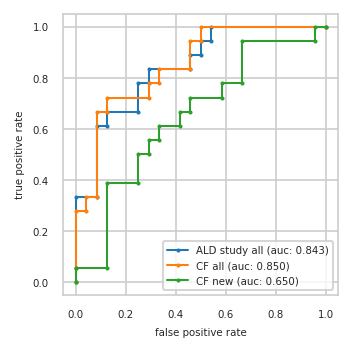

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.333  0.000 0.278  0.125 0.056
3          0.083 0.333  0.042 0.278  0.125 0.389
4          0.083 0.611  0.042 0.333  0.250 0.389
5          0.125 0.611  0.083 0.333  0.250 0.500
6          0.125 0.667  0.083 0.667  0.292 0.500
7          0.250 0.667  0.125 0.667  0.292 0.556
8          0.250 0.778  0.125 0.722  0.333 0.556
9          0.292 0.778  0.292 0.722  0.333 0.611
10         0.292 0.833  0.292 0.778  0.417 0.611
11         0.458 0.833  0.333 0.778  0.417 0.667
12         0.458 0.889  0.333 0.833  0.458 0.667
13         0.500 0.889  0.458 0.833  0.458 0.722
14         0.500 0.944  0.458 0.944  0.583 0.722
15         0.542 0.944  0.500 0.944  0.583 0.778
16         0.542 1.000  0.500 1.000  0.667 0.778
17         1.000 1.000  1.000 1.000  0.667 0.944
18           NaN   NaN    NaN   NaN  0.958 0.944
19           NaN   NaN    NaN   NaN  0.958 1.000
20           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P04075,P10636-2;P10636-6,P31321
1,Q9NRN5,A0A0G2JLV7;A0A0G2JM94;A0A0G2JMI0;A0A0G2JNK8;A0...,O75339
2,P09486,A0A087WZR4,Q14894
3,K7ERG9;P00746,Q9Y2T3;Q9Y2T3-3,A0A0J9YW36;Q9NZ72;Q9NZ72-2
4,P14174,P63104,Q96GD0
5,P10636-2;P10636-6,C9JF17;P05090,O95497
6,P61981,P61981,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3
7,P18428,Q96GD0,A0A075B7B8
8,Q9Y2T3;Q9Y2T3-3,P04075,H0Y7T8;P49418;P49418-2


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


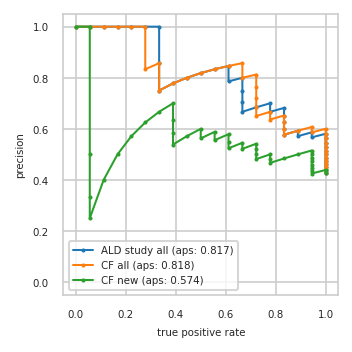

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.425 0.944
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.447 0.944
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.567 0.944     0.600 1.000     0.467 0.778
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.571 0.889     0.607 0.944     0.500 0.778
15         0.593 0.889     0.593 0.889     0.481 0.722
16         0.577 0.833     0.577 0.833     0.500 0.722
17         0.600 0.833     0.600 0.833     0.520 0.722
18         0.625 0.833     0.625 0.833     0.542 0.722
19         0.652 0.833     0.652 0.833     0.522 0.667
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.667 0.778     0.667 0.778     0.524 0.611
22         0.700 0.778     0.650 0.722     0.550 0.611
23         0.684 0.722     0.684 0.722     0.579 0.611
24         0.667 0.667     0.722 0.722     0.556 0.556
25         0.706 0.667     0.765 0.722     0.588 0.556
26         0.750 0.667     0.812 0.722     0.562 0.500
27         0.800 0.667     0.800 0.667     0.600 0.500
28         0.786 0.611     0.857 0.667     0.571 0.444
29         0.846 0.611     0.846 0.611     0.538 0.389
30         0.833 0.556     0.833 0.556     0.583 0.389
31         0.818 0.500     0.818 0.500     0.636 0.389
32         0.800 0.444     0.800 0.444     0.700 0.389
33         0.778 0.389     0.778 0.389     0.667 0.333
34         0.750 0.333     0.750 0.333     0.625 0.278
35         0.857 0.333     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     1.000 0.278     0.400 0.111
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


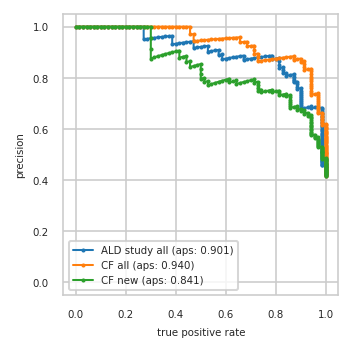

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


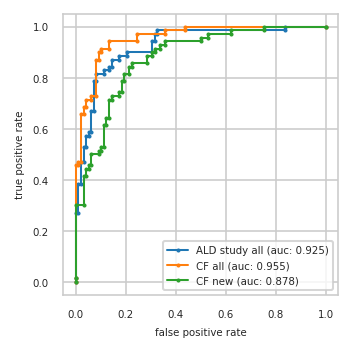

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}